# H02A5A Computer Vision Project - Incisor Segmentation

## Imports

In [1]:
%matplotlib inline
import numpy as np
import cv2
from incisorseg.dataset import Dataset,LeaveOneOutSplitter,load_image,load_landmark
from incisorseg.utils import *
from asm.shape import Shape, ShapeList
from asm.shapemodel import ShapeModel
from asm.greymodel import GreyModel

## Reading the dataset

In [2]:
data = Dataset('../data/')

## Sample plots

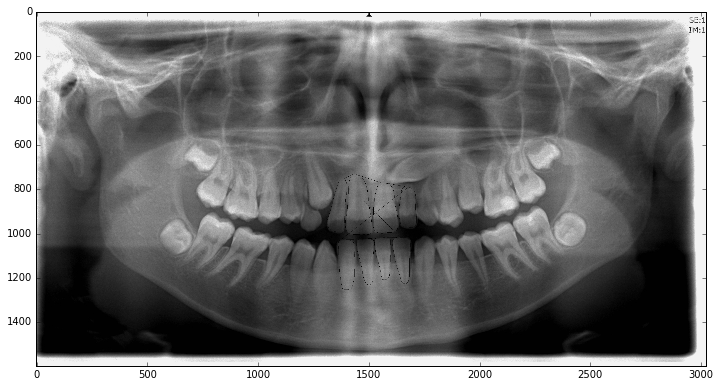

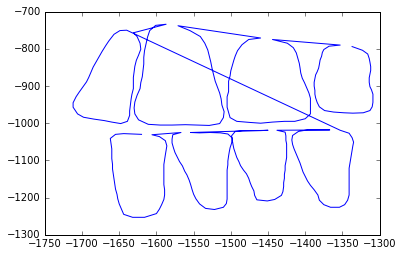

(1597, 3023)


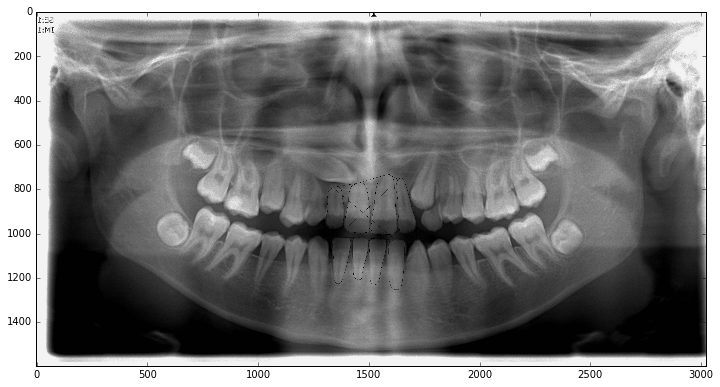

In [3]:
img,mimg = data.get_training_images([0])
lc,mlc = data.get_training_image_landmarks([0],Dataset.ALL_TEETH)
imshow2(overlay_shapes_on_image(img[0],lc))
plot_shapes(mlc)
imshow2(overlay_shapes_on_image(mimg[0],mlc))
print img[0].shape

## Shape Model
All 8 teeth

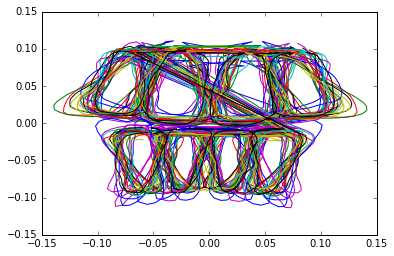

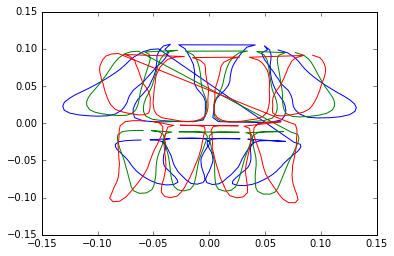

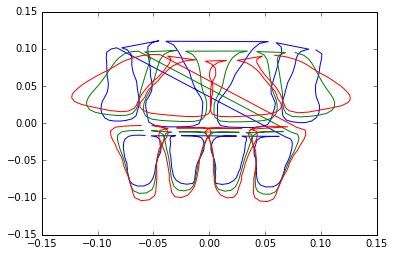

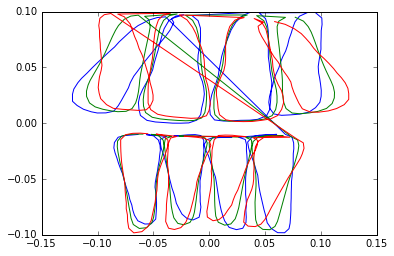

In [4]:
lc,mlc = data.get_training_image_landmarks(Dataset.ALL_TRAINING_IMAGES,Dataset.ALL_TEETH)
landmarks = lc.concatenate(mlc)
model = ShapeModel(ShapeList(landmarks))
plot_shapes(model.aligned_shapes())
#plot_shapes([model.mean_shape()])
plot_shapes(model.mode_shapes(1))
plot_shapes(model.mode_shapes(2))
plot_shapes(model.mode_shapes(3))

### Some edge detection and pyramids

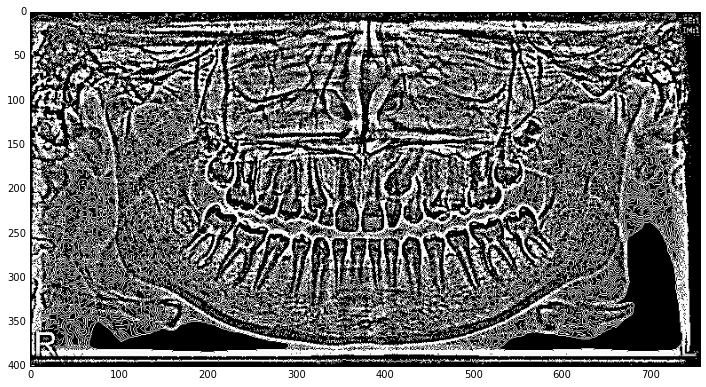

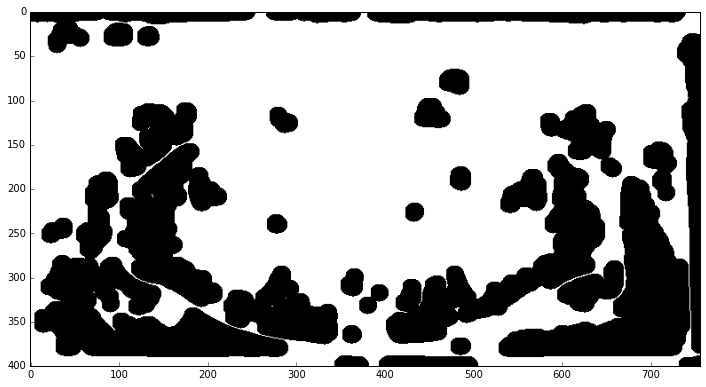

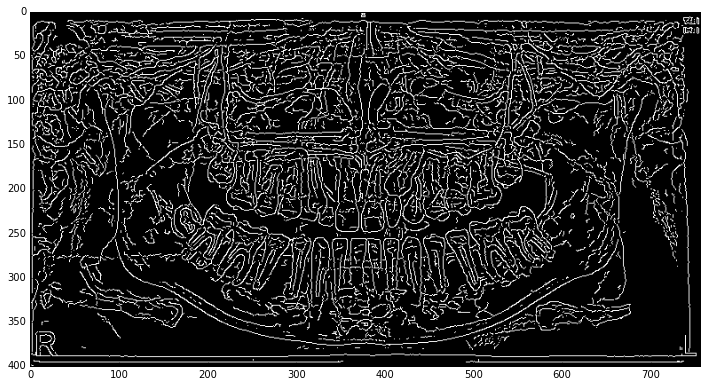

In [5]:
sample = cv2.pyrDown(cv2.pyrDown(data.get_extra_images([0])[0]))#[650:1300,1200:1800]
imshow2(cv2.Laplacian(cv2.bilateralFilter(sample,5,30,30),2))
imshow2(cv2.morphologyEx(cv2.Canny(cv2.bilateralFilter(sample,9,30,30),20,20),cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(20,20))))
imshow2(cv2.Canny(cv2.bilateralFilter(sample,5,30,30),10,20))

#### Shape normals

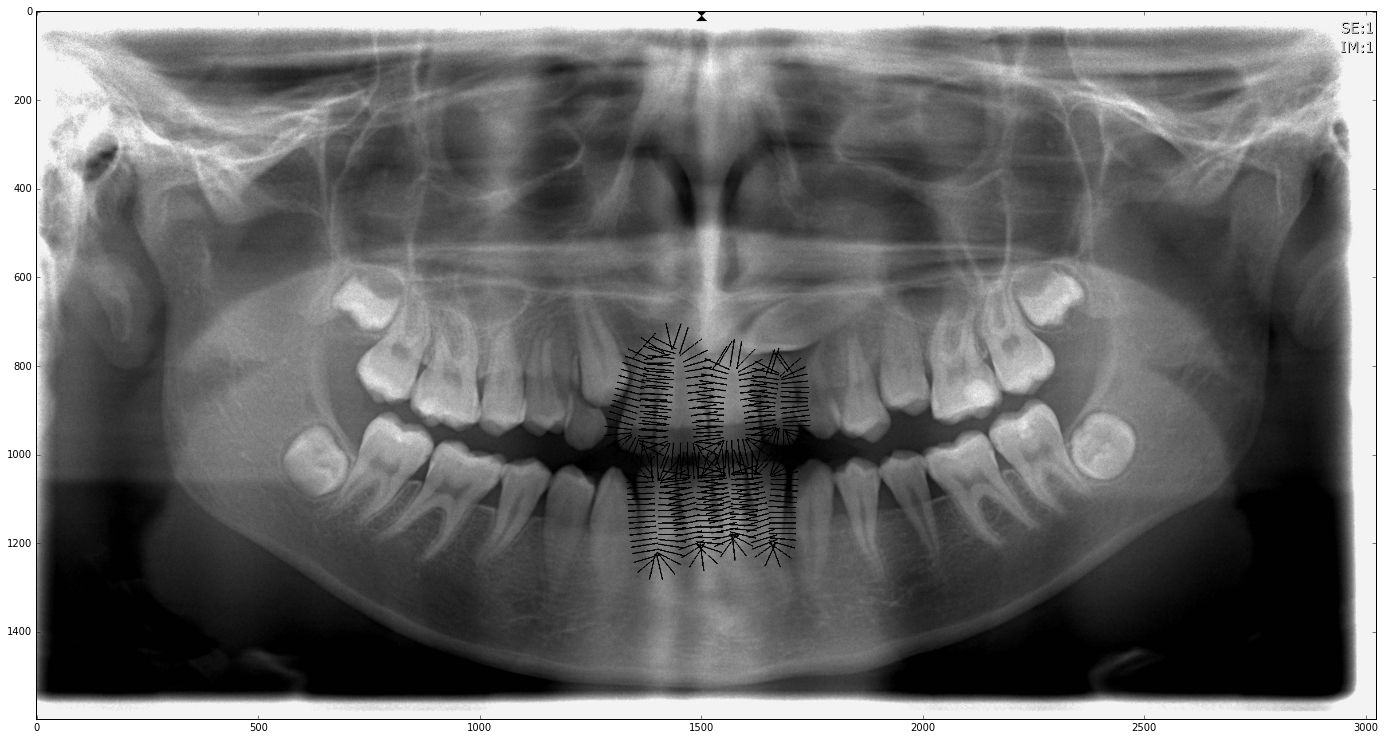

In [6]:
img,_ = data.get_training_images([0])
l,_ = data.get_training_image_landmarks([0],Dataset.ALL_TEETH)
shape = l.tolist()[0]
normal_pixels = []
for i in range(shape.size()):
    generator = shape.get_normal_at_point_generator(i, 2)
    for increment in range(-30, 31):
        coordinates = np.int32(np.round(generator(increment)))
        normal_pixels.append(coordinates.tolist())
imshow2(overlay_points_on_image(img[0],normal_pixels),width=24,height=24)

#### Grey Level pixels for the shape normals

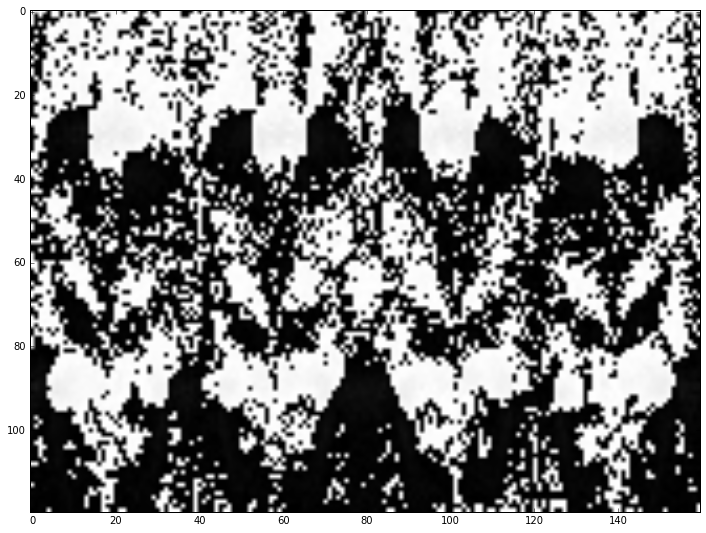

In [7]:
img,mimg = data.get_training_images(Dataset.ALL_TRAINING_IMAGES)
l,ml = data.get_training_image_landmarks(Dataset.ALL_TRAINING_IMAGES,Dataset.ALL_TEETH)
images = img + mimg
shapes = l.concatenate(ml)
greymodel = GreyModel(images,shapes,number_of_pixels=30,normalize=True,use_gradient=True)
img = np.array([greymodel.grey_model_point(point_index).mean() for point_index in range(greymodel.size())])
img = np.concatenate((img[:][:160],img[:][160:]),axis=1)
imshow2(np.uint8(np.round(100*img.T),width=24,height=24))

#### Fun with pyramids

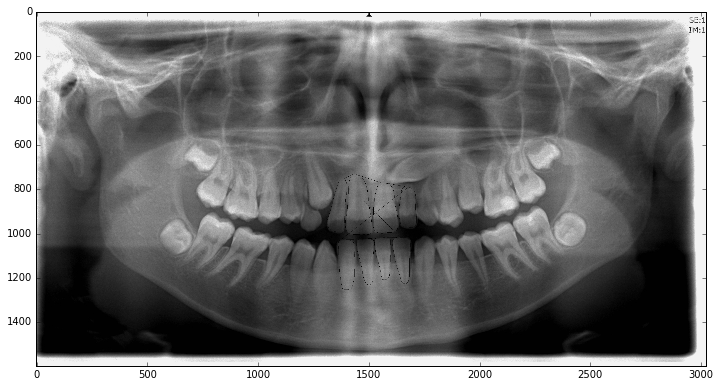

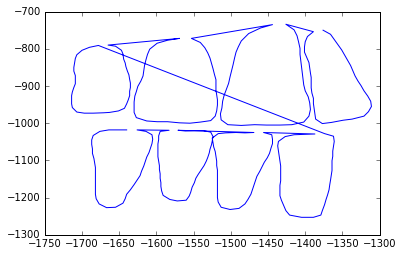

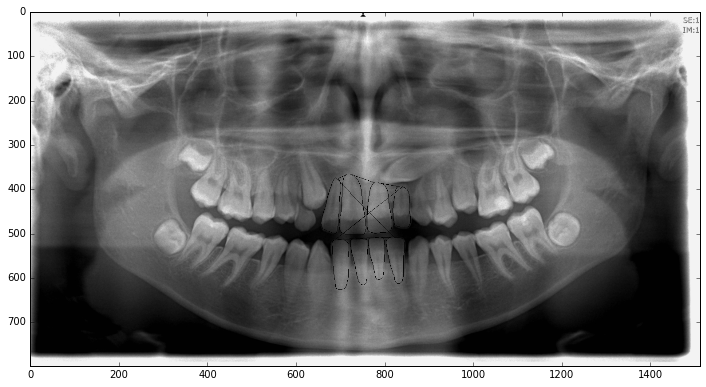

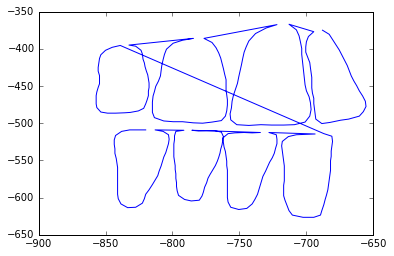

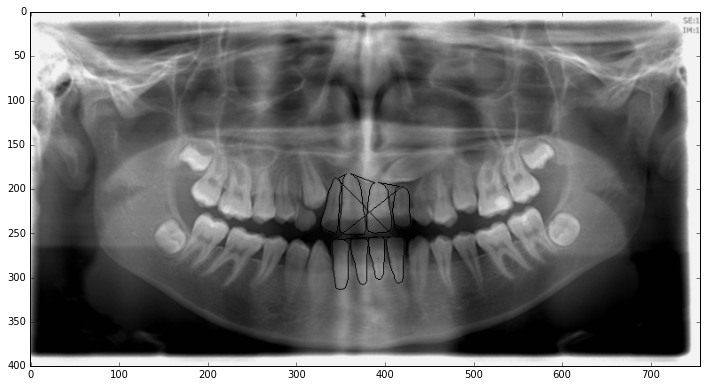

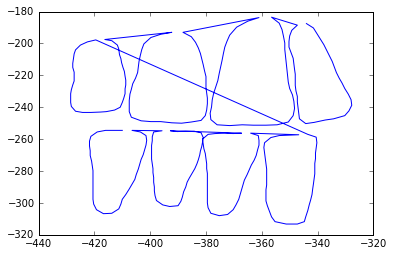

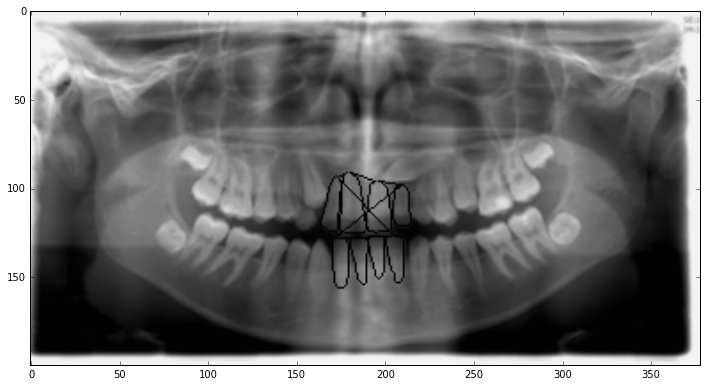

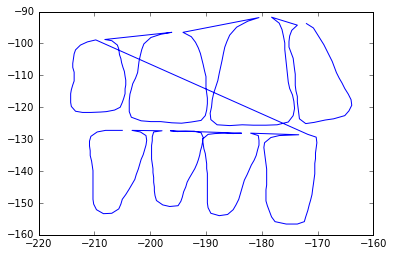

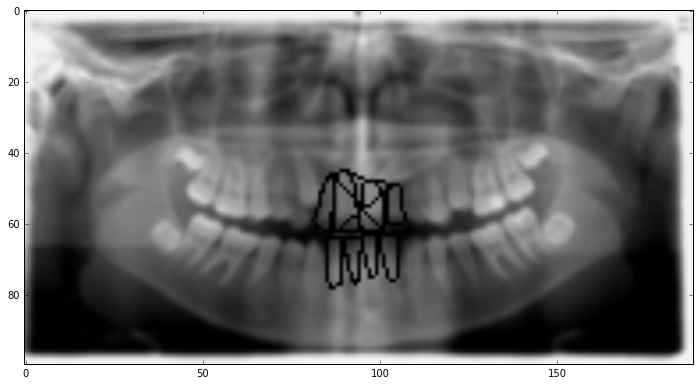

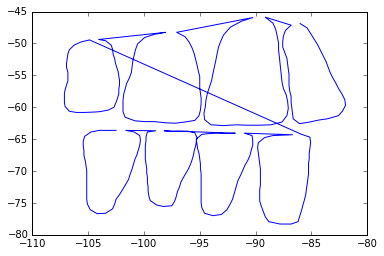

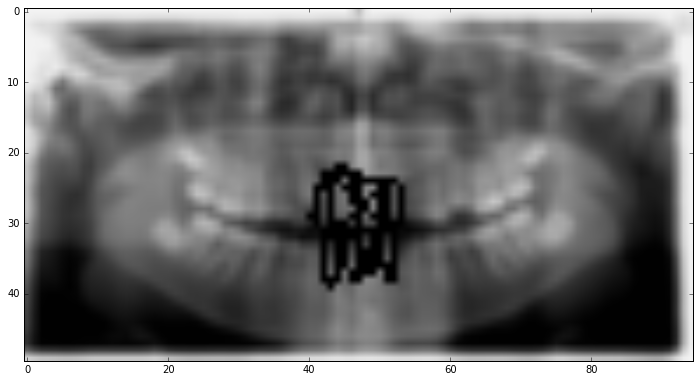

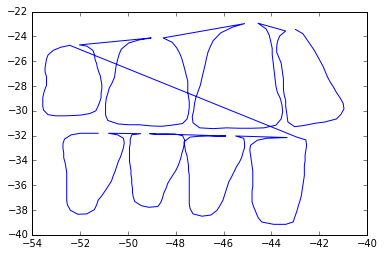

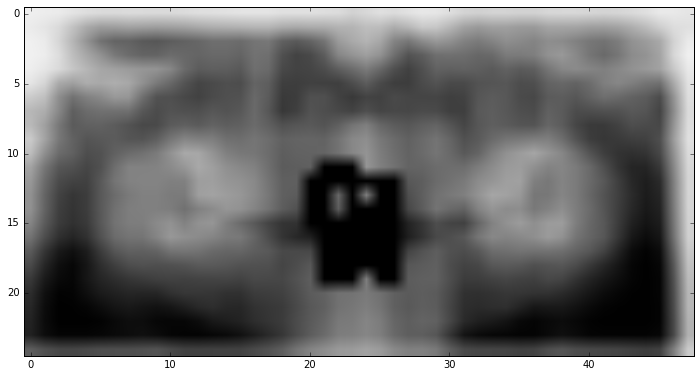

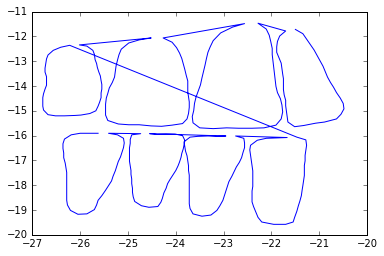

In [8]:
pimg = images[0]
shape = shapes[0]
for i in range(7):
    imshow2(overlay_shapes_on_image(pimg,[shape]))
    plot_shapes([shape])
    pimg = cv2.pyrDown(pimg)
    shape = shape.pyr_down()

#### Leave 1 out CV

In [9]:
for split in LeaveOneOutSplitter(data):
    training_images,training_landmarks,training_segmentations = split.get_training_set()
    shape_model = ShapeModel(training_landmarks)
    test_image,test_landmark,test_segmentation = split.get_test_example()
    print split.get_dice_error_on_test(test_landmark)
    print split.get_dice_error_on_test(test_landmark,True)
    print split.get_dice_error_on_test(shape_model.mean_shape_projected())
    print split.get_dice_error_on_test(shape_model.mean_shape_projected(),True)

0.720707254052
1.0
0.461933256211
0.427925271599
0.669511433775
1.0
0.51763672703
0.574747906556
0.729179738404
1.0
0.458450282601
0.467966276746
0.637585157835
1.0
0.531786659942
0.580279397289
0.709117801352
1.0
0.505642261263
0.44101417983
0.729491151966
1.0
0.498405702242
0.459051233851
0.724374616493
1.0
0.565048930469
0.676830543204
0.77594077993
1.0
0.407042661759
0.374017315491
0.739836868925
1.0
0.420111253744
0.402096614074
0.688420985772
1.0
0.326198106644
0.328751789665
0.746843293974
1.0
0.443837654059
0.444446247991
0.742366518199
1.0
0.4026496073
0.408623414918
0.73442359028
1.0
0.373484933348
0.407805022056
0.74423645432
1.0
0.523095665486
0.467938385869
0.71908182386
1.0
0.469249688869
0.432326070825
0.663929844849
1.0
0.505859022895
0.549168142908
0.724063927488
1.0
0.358103268322
0.389974682472
0.626929818866
1.0
0.531348436358
0.58756871413
0.706354587421
1.0
0.527981611908
0.485535963236
0.726144010536
1.0
0.510387840988
0.479054942525
0.719348130544
1.0
0.54529991

/usr/lib/python2.7/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


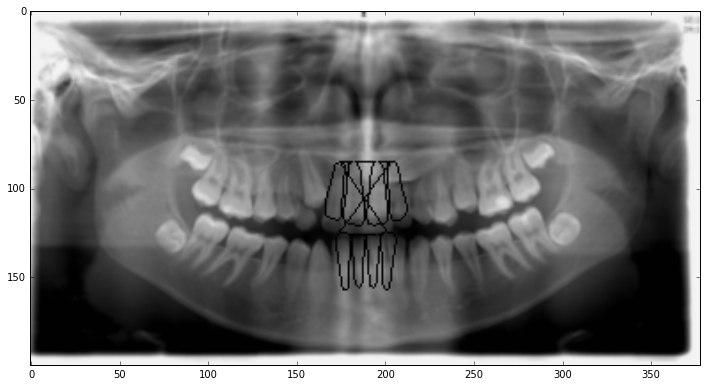

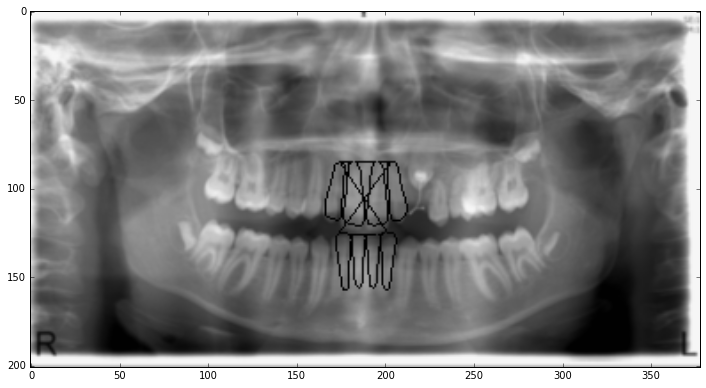

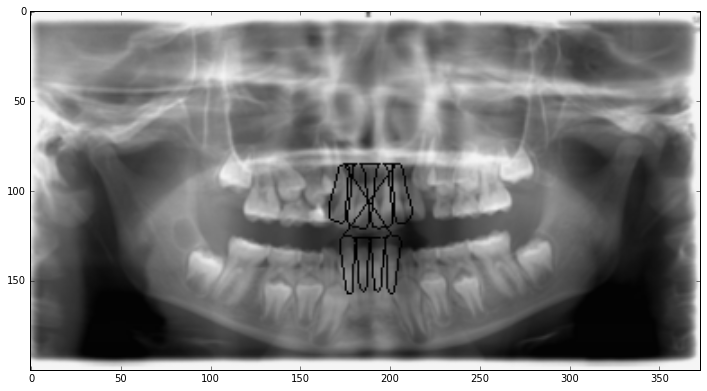

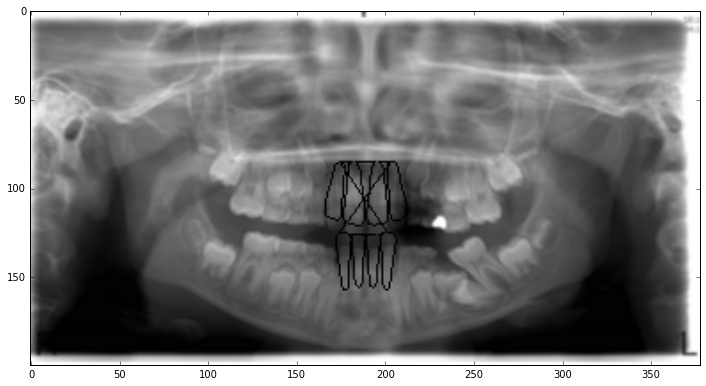

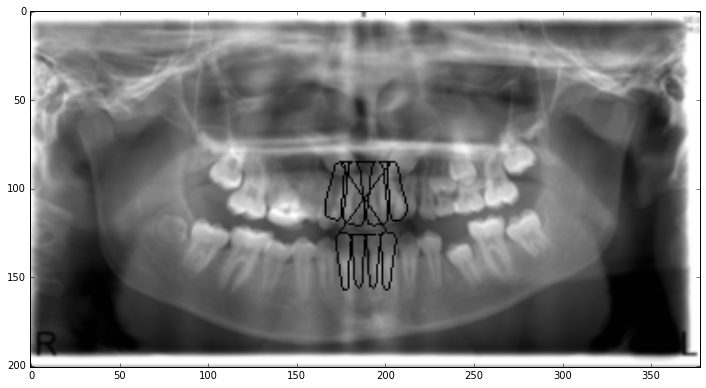

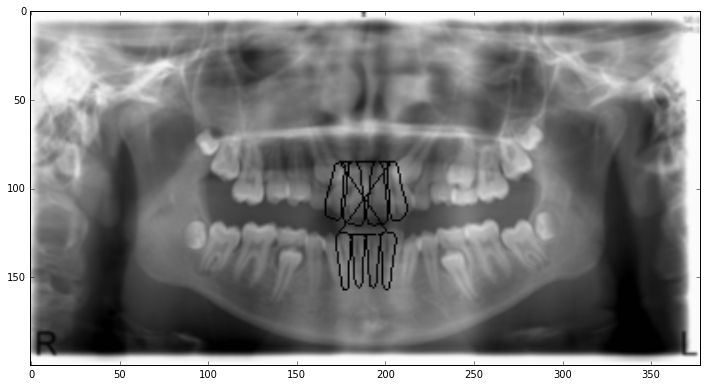

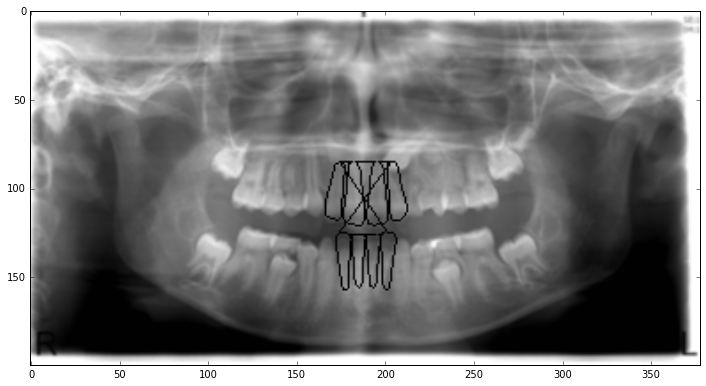

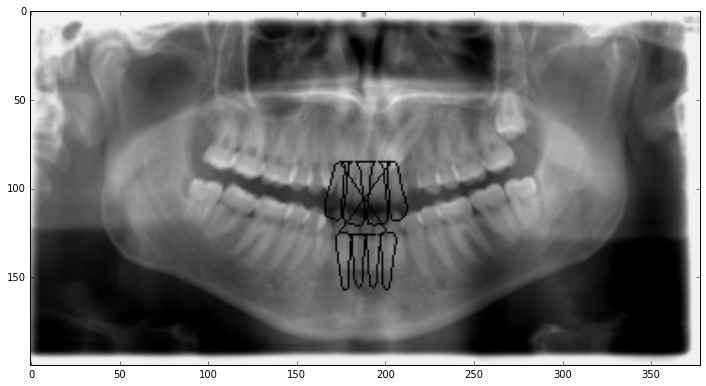

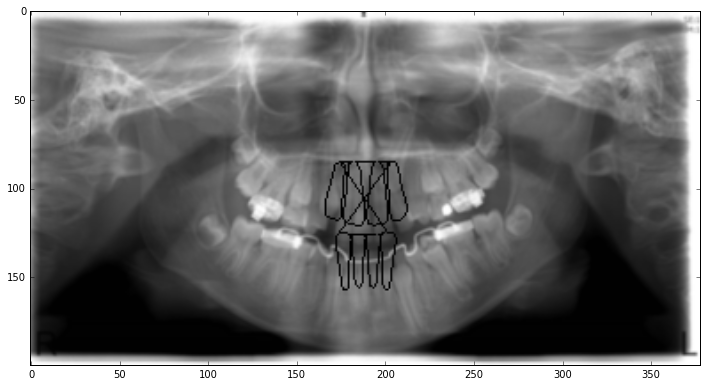

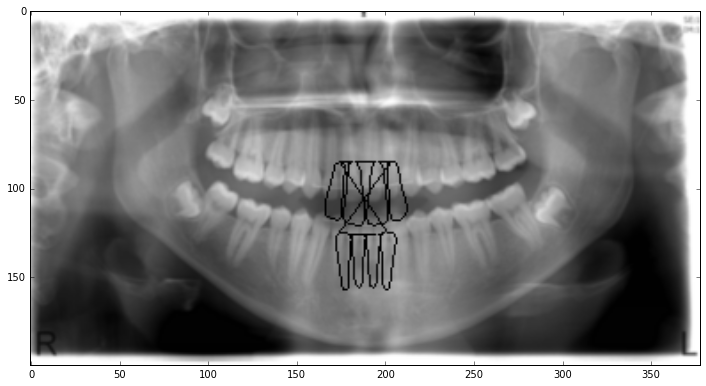

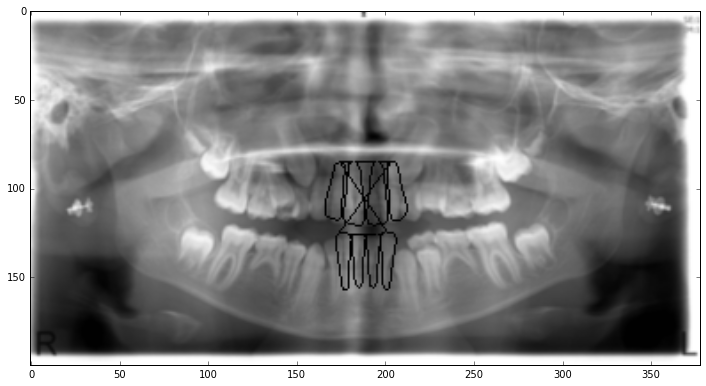

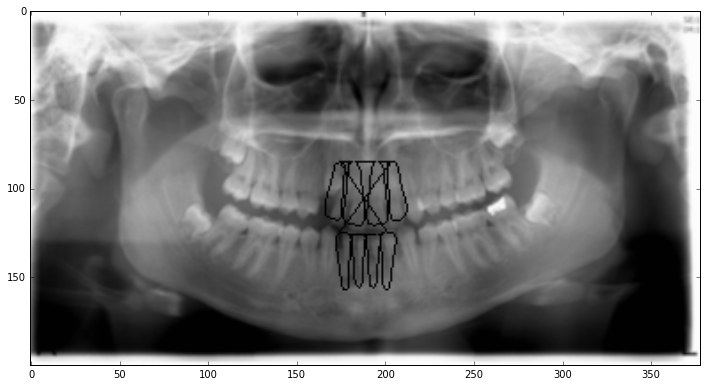

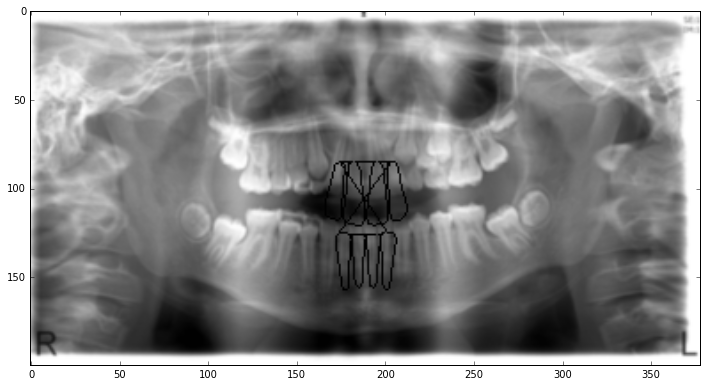

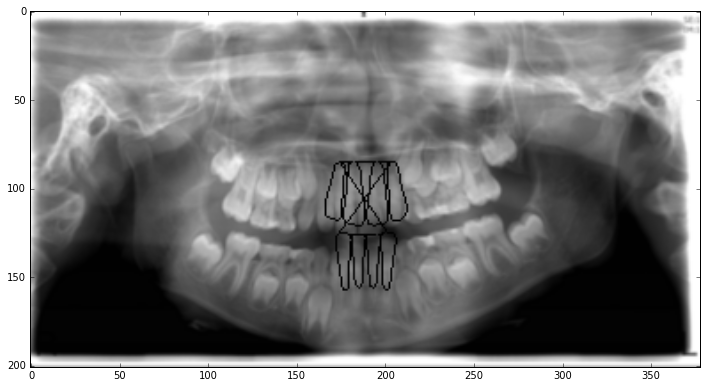

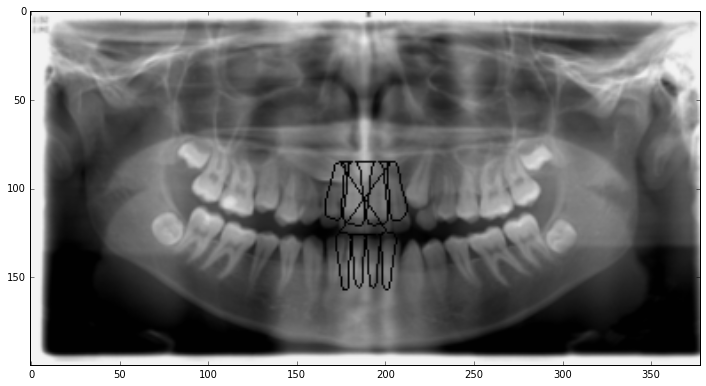

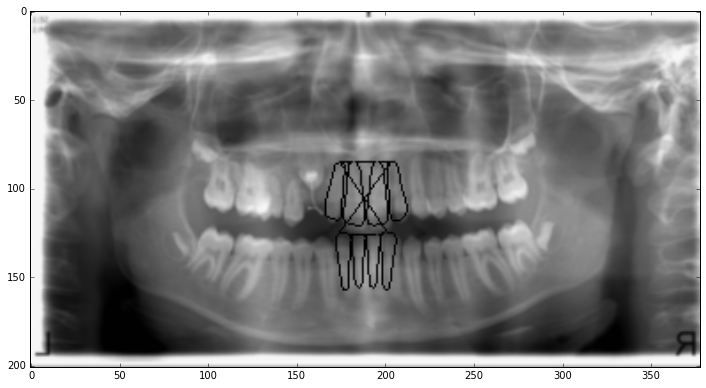

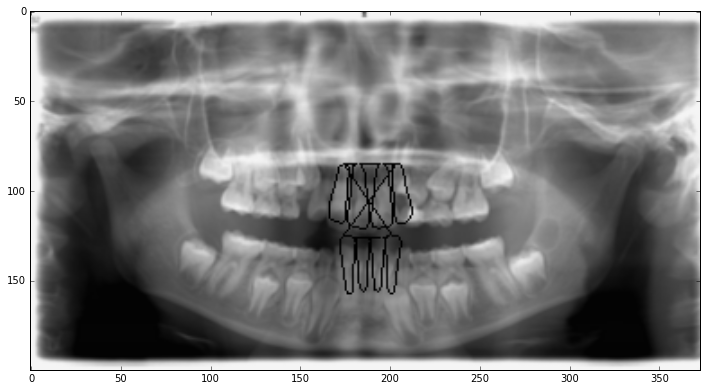

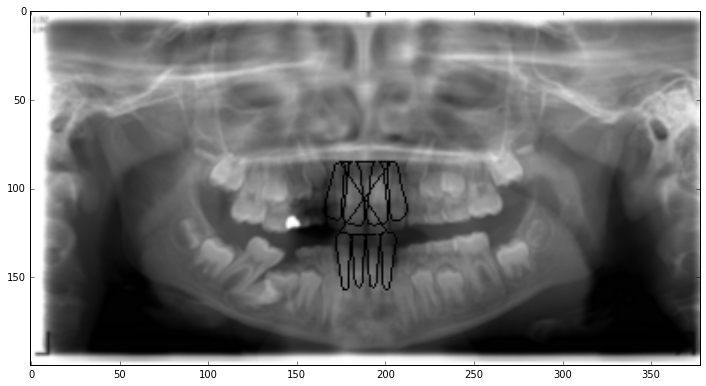

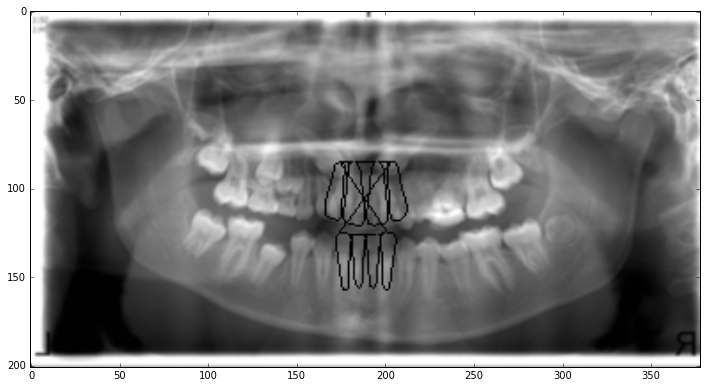

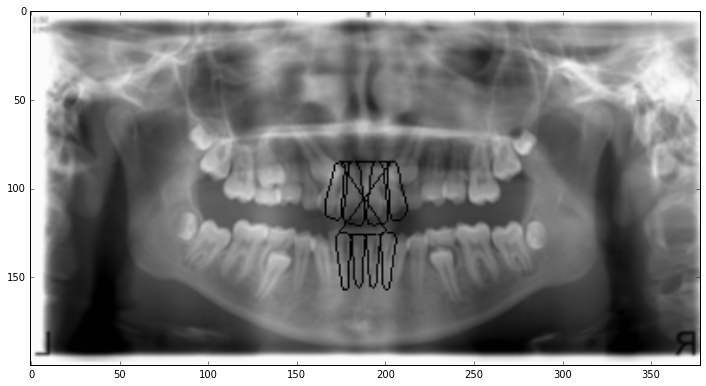

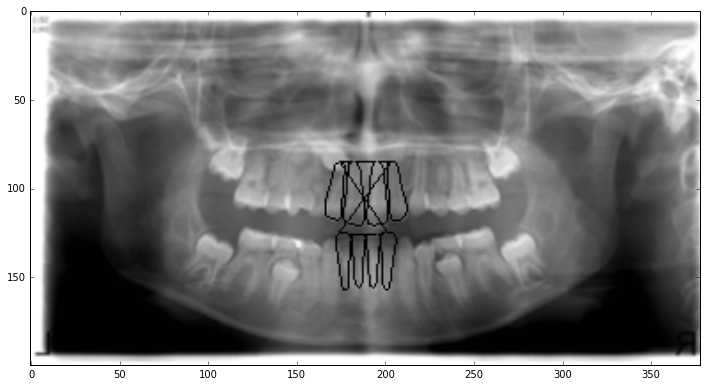

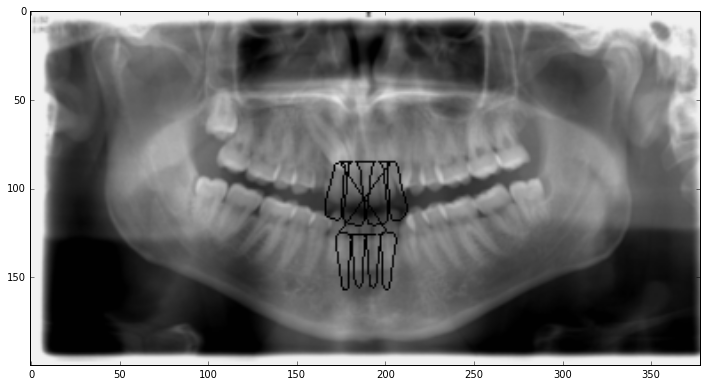

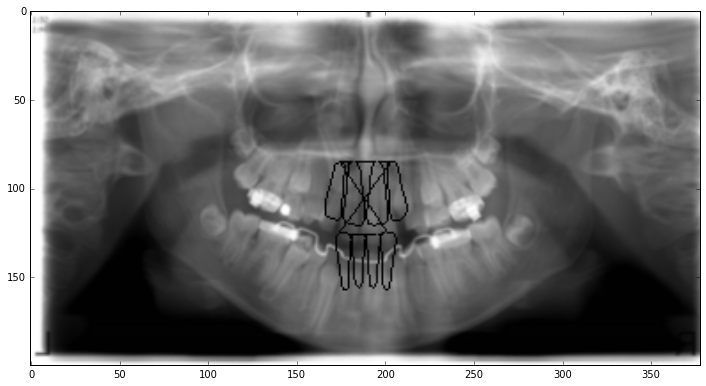

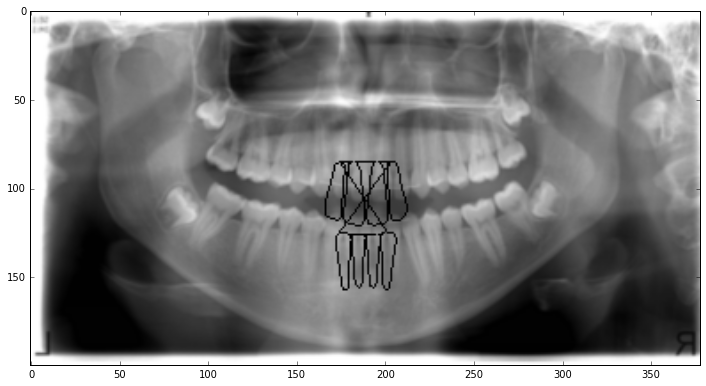

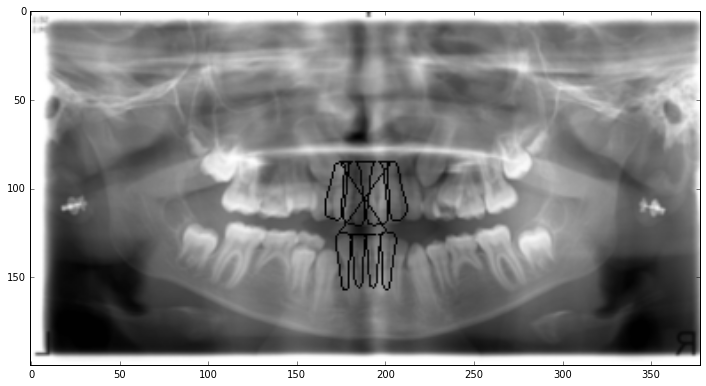

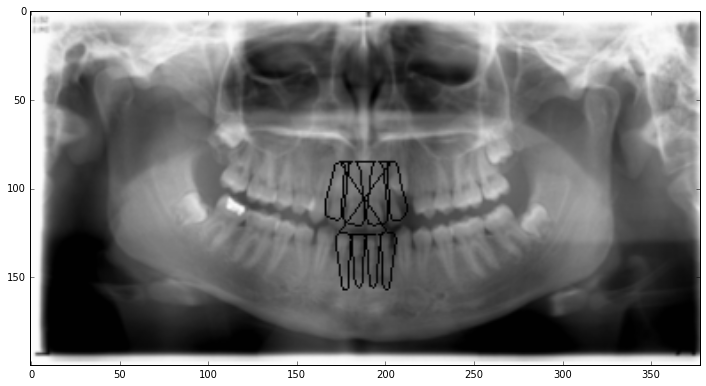

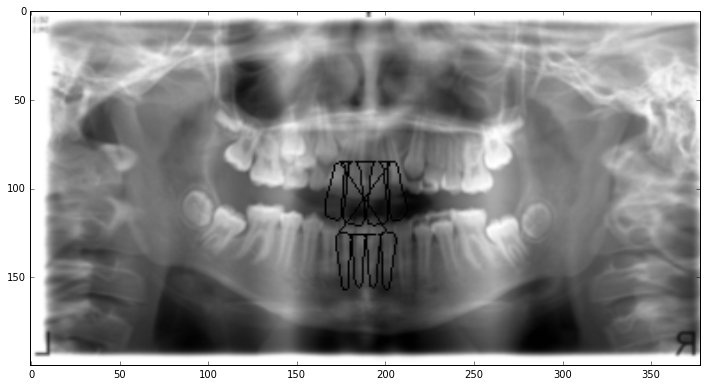

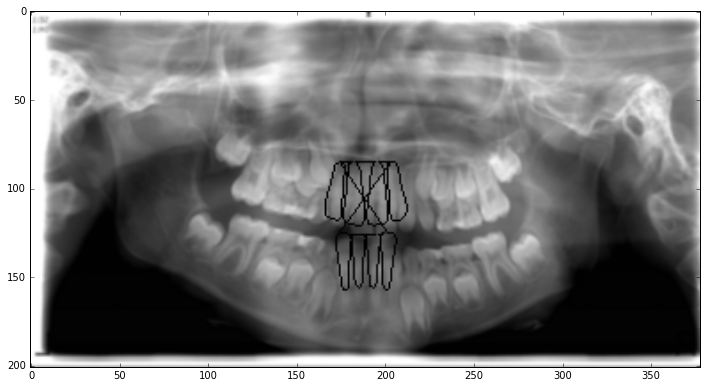

In [10]:
starting_shape = model.mean_shape_projected()
for pimg in images:
    starting_shape_image = starting_shape
    for i in range(4):
        if i==3:
            imshow2(overlay_shapes_on_image(pimg,[starting_shape_image.round()]))
        pimg = cv2.pyrDown(pimg)
        starting_shape_image = starting_shape_image.pyr_down()
